Implementation of AC-GAN paper for MNIST-FashionMNIST-CIFAR datasets. 
##[Paper](https://arxiv.org/pdf/1610.09585.pdf)

In [55]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid, save_image

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cuda:0


In [56]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
train_images = CIFAR10("sample_data", train=True, transform=transform, download=True)

N_classes = len(train_images.classes) 
BATCH_SIZE = 100  # Size of minibatches
LATENT_DIM = 100  # Dimension size for the random noise Z
INITIAL_MAP_SIZE = 4   # Dimension size for the initial SxS images generated from the noise

train_images.classes

Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [57]:
### GENERATOR

class UpSampleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UpSampleConv, self).__init__()
    self.up = nn.Upsample(scale_factor=2)
    self.batch_norm = nn.BatchNorm2d(in_channels)
    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=5, padding=2)

  def forward(self, x):
    out = self.batch_norm(x)
    out = self.up(out)
    out = self.conv(out)
    out = F.relu(out)
    return out

class GenModel(nn.Module):
  def __init__(self, initial_channels=24, latent_dim=LATENT_DIM, initial_map=INITIAL_MAP_SIZE, out_channels=3):
    super(GenModel, self).__init__()
    self.initial_map_size = initial_map
    self.initial_channels = initial_channels
    self.batch_norm = nn.BatchNorm2d(initial_channels)
    self.linear = nn.Linear(in_features=latent_dim, out_features=initial_channels * initial_map * initial_map)
    self.upsample = nn.Sequential(
        UpSampleConv(in_channels=24, out_channels=192),
        UpSampleConv(in_channels=192, out_channels=96),
        UpSampleConv(in_channels=96, out_channels=out_channels),
    )
  
  def forward(self, x):
    result = F.relu(self.linear(x))
    result = result.view(-1, self.initial_channels, self.initial_map_size, self.initial_map_size)
    result = self.batch_norm(result)
    
    result = torch.tanh(self.upsample(result))
    
    return result


### DISCRIMINATOR
# Multi-task -> predicts source (valid or fake) as well as class probability.
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride, padding=1, batch_norm=True):
    super(ConvBlock, self).__init__()
    blocks = [
              nn.Conv2d(
                  in_channels=in_channels, 
                  out_channels=out_channels, 
                  kernel_size=3, 
                  stride=stride, 
                  padding=padding
              ),
              nn.LeakyReLU(0.2),
              nn.Dropout(0.5)
    ]
    if batch_norm:
      blocks.insert(0, nn.BatchNorm2d(in_channels))
    self.layers = nn.Sequential(*blocks)

  def forward(self, x):
    return self.layers(x)


class DiscModel(nn.Module):
  def __init__(self, in_channels=1, out_classes=N_classes):
    super(DiscModel, self).__init__()
    self.convs = nn.Sequential(
        ConvBlock(in_channels=in_channels, out_channels=16, stride=2, batch_norm=False),
        ConvBlock(in_channels=16, out_channels=32, stride=1),
        ConvBlock(in_channels=32, out_channels=64, stride=2),
        ConvBlock(in_channels=64, out_channels=128, stride=1),
        ConvBlock(in_channels=128, out_channels=256, stride=2),
        ConvBlock(in_channels=256, out_channels=512, stride=1),
    )

    self.source_prediction = nn.Linear(in_features=512 * 4 * 4, out_features=2)
    self.class_prediction = nn.Linear(in_features=512 * 4 * 4, out_features=out_classes)
  
  def forward(self, x):
    out = self.convs(x)

    out = out.flatten(1)

    return self.source_prediction(out), self.class_prediction(out)

In [58]:
def generate_noise_input(batch_size, latent_dim):
  noise = torch.normal(mean=0, std=1, size=(batch_size, latent_dim)).to(device)
  random_labels = torch.randint(low=0, high=N_classes, size=(batch_size,)).to(device)
  one_hot_labels = nn.functional.one_hot(random_labels, num_classes=N_classes)

  generated_input = torch.cat([noise, one_hot_labels], 1)

  return generated_input, random_labels


def generate_eval_input(size, latent_dim):
  noise = torch.normal(mean=0, std=1, size=(size, latent_dim)).to(device)
  
  fixed_labels = (torch.arange(size) % N_classes).to(device)
  one_hot_labels = nn.functional.one_hot(fixed_labels, num_classes=N_classes)

  generated_input = torch.cat([noise, one_hot_labels], 1)

  return generated_input, fixed_labels


def adversarial_train(generator, discriminator, gen_optim, disc_optim, data_loader, loss_function, latent_dim=LATENT_DIM, batch_size=BATCH_SIZE, epochs=50):
  real_label = torch.ones(batch_size).long().to(device)
  fake_label = torch.zeros(batch_size).long().to(device)

  evaluation_input, _ = generate_eval_input(100, latent_dim)  

  gen_losses = []
  accuracies = []
  disc_fake_losses = []
  disc_valid_losses = []

  for current_epoch in range(epochs):
    start = time.time()

    gen_loss = 0
    disc_loss_valid = 0
    disc_loss_fake = 0
    all_source_predictions = []

    for real_images, real_classes in data_loader:
      generator_input, generated_classes = generate_noise_input(len(real_classes), latent_dim)

      # Train Generator 
      gen_optim.zero_grad()

      gen_images = generator(generator_input)
      fake_data_source_predictions, fake_data_class_predictions = discriminator(gen_images)
      
      # Generator tries to FOOL the discriminator, so target is real_label here.
      gen_cost = loss_function(fake_data_source_predictions, real_label[:len(real_classes)]) + loss_function(fake_data_class_predictions, generated_classes)
      gen_cost.backward()
      gen_optim.step()

      # Train Discriminator
      disc_optim.zero_grad()

      real_data_source_predictions, real_data_class_predictions = discriminator(real_images.to(device))
      fake_data_source_predictions, fake_data_class_predictions = discriminator(gen_images.detach())  # Important to detch here.

      # Discriminator cost on real data
      disc_real_cost = (loss_function(real_data_source_predictions, real_label[:len(real_classes)]) + loss_function(real_data_class_predictions, real_classes.to(device))) /2
      
      # Discriminator cost on fake data
      disc_fake_cost = (loss_function(fake_data_source_predictions, fake_label[:len(real_classes)]) + loss_function(fake_data_class_predictions, generated_classes)) / 2

      disc_total_cost = (disc_real_cost + disc_fake_cost) / 2
      disc_total_cost.backward()
      disc_optim.step()

      all_source_predictions.extend(torch.argmax(fake_data_source_predictions, dim=1).cpu().numpy())

      gen_loss += gen_cost.item()
      disc_loss_valid += disc_real_cost.item()
      disc_loss_fake += disc_fake_cost.item()
    
    gen_losses.append(gen_loss / len(data_loader))
    disc_fake_losses.append(disc_loss_fake / len(data_loader))
    disc_valid_losses.append(disc_loss_valid / len(data_loader))

    gen_images = generator(evaluation_input)
    grid = make_grid(gen_images)
    save_image(grid, f"sample_data/{current_epoch + 1}.png")

    disc_fake_accuracy = accuracy_score(np.zeros(len(all_source_predictions)), all_source_predictions)
    accuracies.append(disc_fake_accuracy)
    
    print(f"Epoch {current_epoch + 1} | "
          f"Accuracy {disc_fake_accuracy:.2f} | "
          f"Gen Loss {(gen_loss / len(data_loader)):.6f} | "
          f"Disc Fake Loss {(disc_loss_fake / len(data_loader)):.6f} | "
          f"Disc Valid Loss {(disc_loss_valid / len(data_loader)):.6f}| "
          f"Time {(time.time() - start):.2f} sec")

  return gen_losses, disc_fake_losses, disc_valid_losses, accuracies

In [59]:
train_dataloader = DataLoader(train_images, batch_size=BATCH_SIZE, num_workers=8, pin_memory=True)

generator = GenModel(latent_dim=LATENT_DIM + N_classes, out_channels=3).to(device)
discriminator = DiscModel(in_channels=3).to(device)

gen_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

cost_function = nn.CrossEntropyLoss().to(device)

Epoch 1 | Accuracy 0.67 | Gen Loss 3.315131 | Disc Fake Loss 1.381204 | Disc Valid Loss 1.332792| Time 24.20 sec
Epoch 2 | Accuracy 0.62 | Gen Loss 1.718887 | Disc Fake Loss 0.723011 | Disc Valid Loss 1.269635| Time 24.15 sec
Epoch 3 | Accuracy 0.62 | Gen Loss 1.235921 | Disc Fake Loss 0.481207 | Disc Valid Loss 1.205419| Time 24.15 sec
Epoch 4 | Accuracy 0.63 | Gen Loss 1.196087 | Disc Fake Loss 0.457208 | Disc Valid Loss 1.159044| Time 24.14 sec
Epoch 5 | Accuracy 0.63 | Gen Loss 1.179052 | Disc Fake Loss 0.445378 | Disc Valid Loss 1.124517| Time 24.13 sec
Epoch 6 | Accuracy 0.63 | Gen Loss 1.159114 | Disc Fake Loss 0.437657 | Disc Valid Loss 1.095883| Time 24.24 sec
Epoch 7 | Accuracy 0.62 | Gen Loss 1.131535 | Disc Fake Loss 0.433792 | Disc Valid Loss 1.077748| Time 24.17 sec
Epoch 8 | Accuracy 0.63 | Gen Loss 1.144550 | Disc Fake Loss 0.428695 | Disc Valid Loss 1.058514| Time 24.22 sec
Epoch 9 | Accuracy 0.63 | Gen Loss 1.130267 | Disc Fake Loss 0.423150 | Disc Valid Loss 1.043689

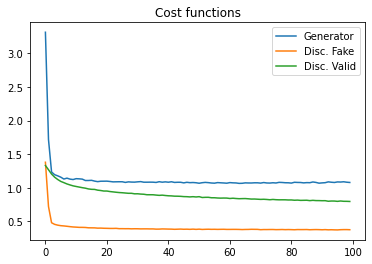

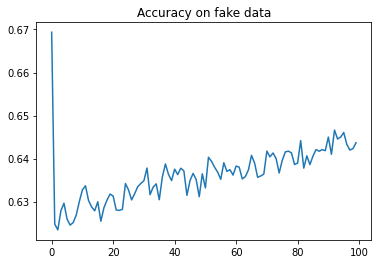

In [60]:
N_EPOCHS = 100

gen_losses, disc_fake_losses, disc_valid_losses, accuracies = adversarial_train(generator, discriminator, gen_optim, disc_optim, train_dataloader, cost_function, epochs=N_EPOCHS)

plt.plot(range(N_EPOCHS), gen_losses, label="Generator")
plt.plot(range(N_EPOCHS), disc_fake_losses, label="Disc. Fake")
plt.plot(range(N_EPOCHS), disc_valid_losses, label="Disc. Valid")
plt.legend()
plt.title("Cost functions")
plt.show()

plt.plot(range(N_EPOCHS), accuracies)
plt.title("Accuracy on fake data")
plt.show()

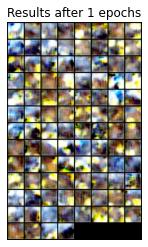

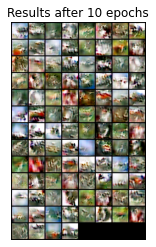

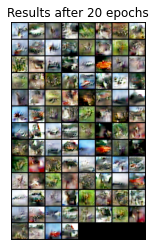

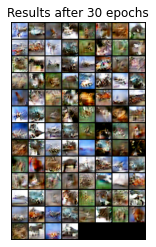

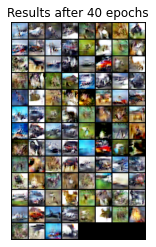

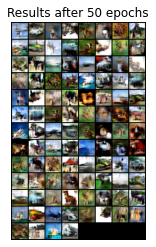

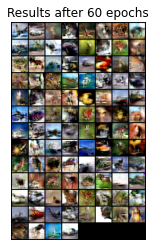

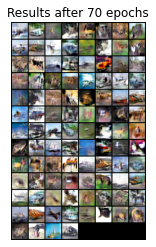

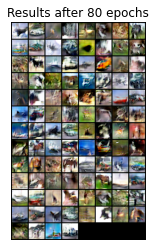

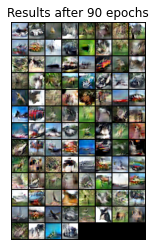

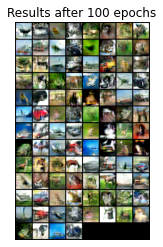

In [61]:
image = Image.open(f'sample_data/1.png')
plt.imshow(image)
plt.title(f"Results after 1 epochs")
plt.axis('off')
plt.show()

for i in range(10, N_EPOCHS + 1, 10):
  image = Image.open(f'sample_data/{i}.png')
  plt.imshow(image)
  plt.title(f"Results after {i} epochs")
  plt.axis('off')
  plt.show()